In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb
# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [ ]:
types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv("train_v2.csv", parse_dates=[2], nrows=66901, dtype=types)
store = pd.read_csv("store.csv")

In [ ]:
not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))

No closed store with sales: True


In [ ]:
no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))

No open store with no sales: True


In [ ]:
train = train.loc[train['Sales'] > 0]
assert(train[train['Sales'] == 0].size == 0)

In [ ]:
dates = pd.to_datetime(train['Date'], format="%Y%m%d:%H:%M:%S.%f").sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values
assert(all(dates == date_range))

Start date:  2014-11-26T00:00:00.000000000
End Date:  2015-01-30T00:00:00.000000000


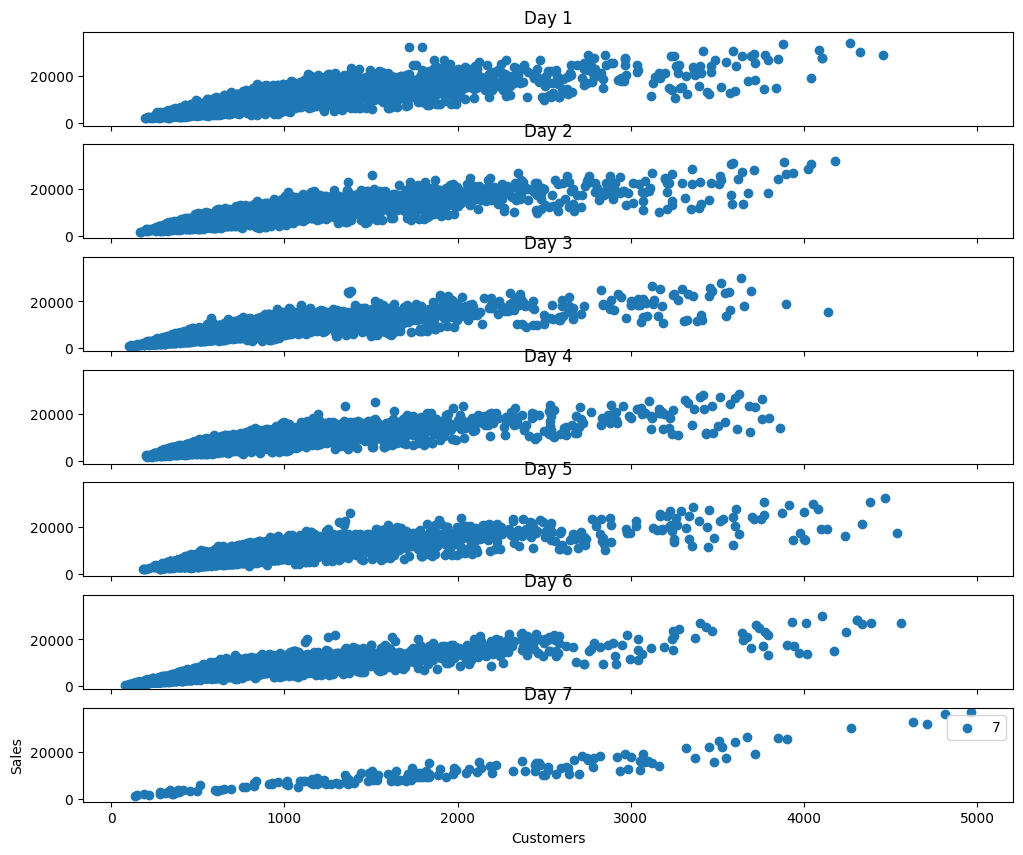

In [ ]:
f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    mask = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

<ipython-input-12-3616624ade31>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))


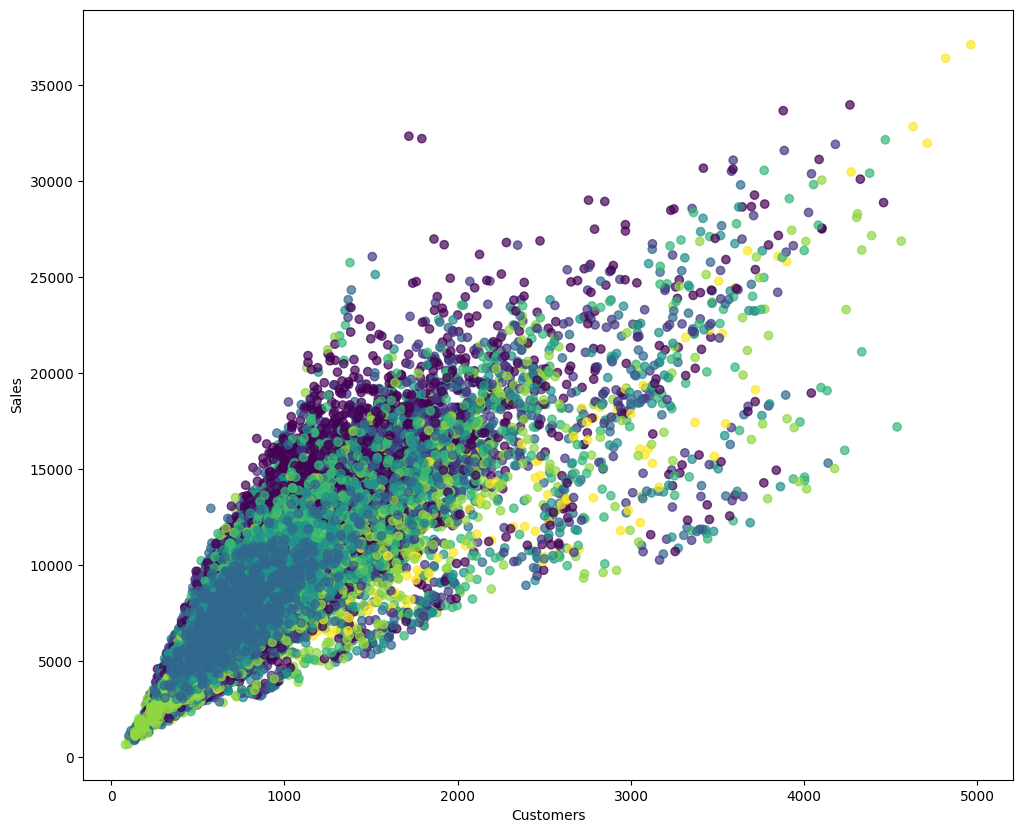

In [ ]:
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

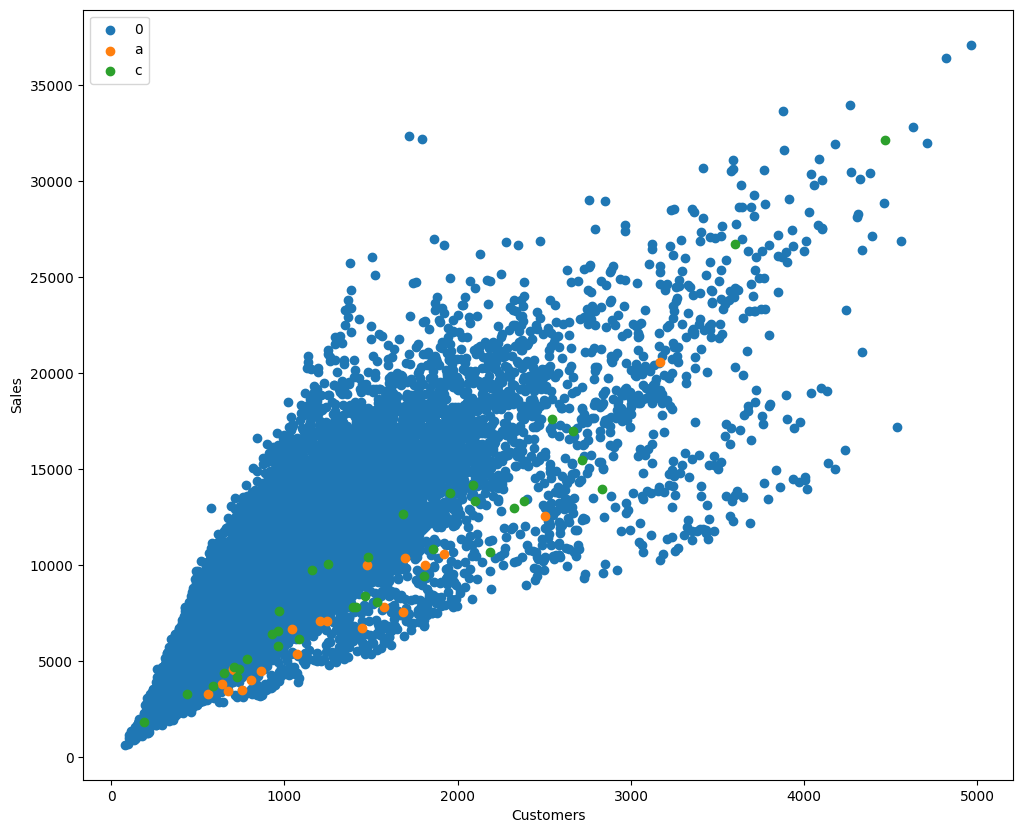

In [ ]:
for i in ["0", "a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

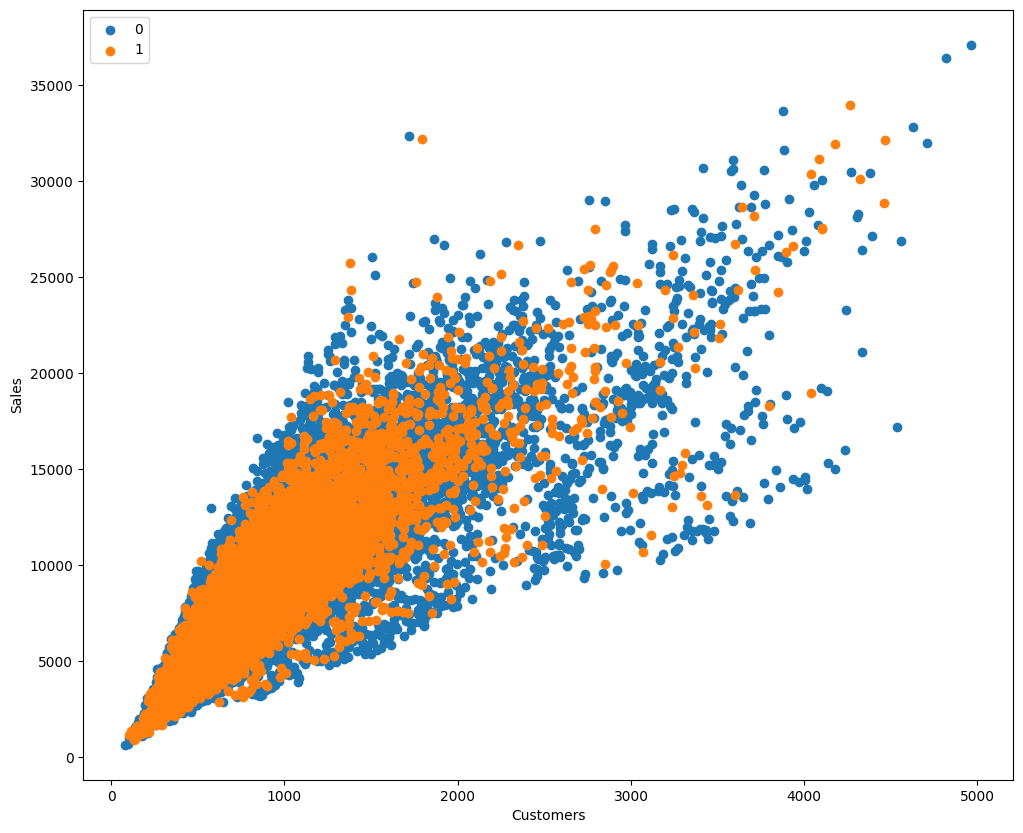

In [ ]:
for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

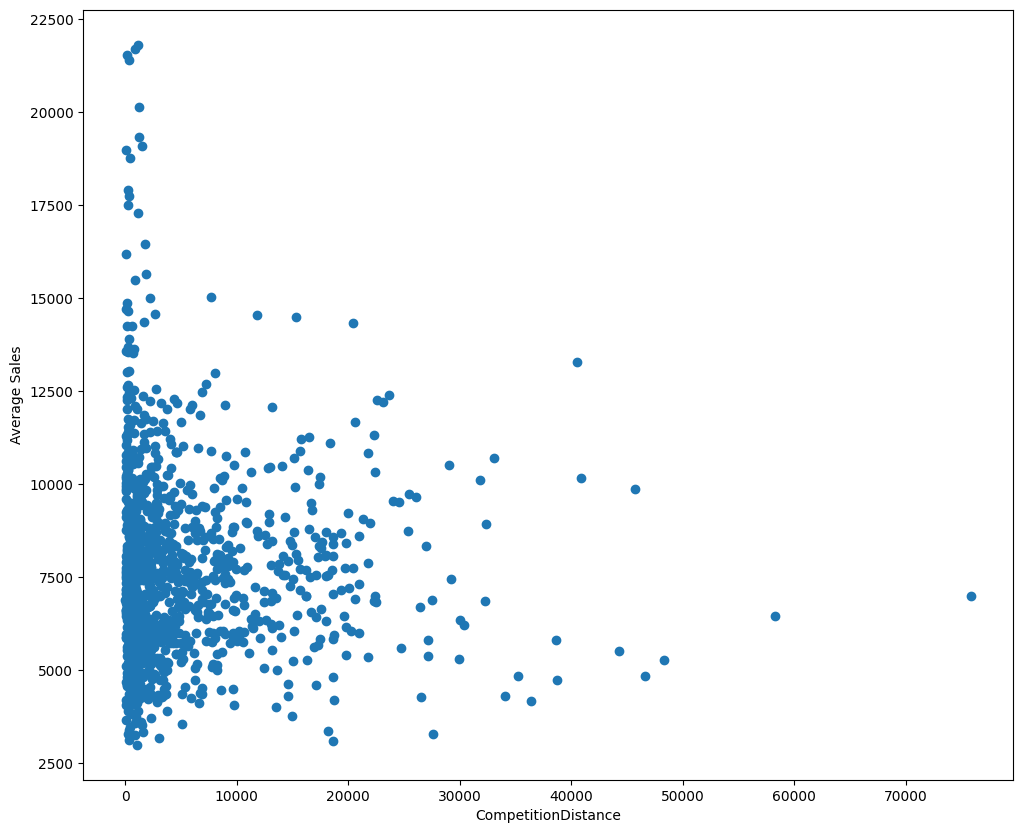

In [ ]:
# fill NaN values
store["CompetitionDistance"].fillna(-1)
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()

In [ ]:
def build_features(train, store):
    # Convert string types into integers
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes

    merged = pd.merge(train, store, on='Store', how='left')

    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)

    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    merged['Week'] = merged.Date.dt.week

    # Number of months that competition has existed for
    merged['MonthsCompetitionOpen'] = \
        12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + \
        (merged['Month'] - merged['CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear'] ==
               NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace

    # Number of weeks that promotion has existed for
    merged['WeeksPromoOpen'] = \
        12 * (merged['Year'] - merged['Promo2SinceYear']) + \
        (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear'] ==
                  NaN_replace, 'WeeksPromoOpen'] = NaN_replace

    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek',
        'Promo2SinceYear',
        'MonthsCompetitionOpen',
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)

    return merged

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()

<ipython-input-28-8a9a0b9b30d9>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  merged['Week'] = merged.Date.dt.week
<ipython-input-28-8a9a0b9b30d9>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-01-30,5577,616,1,1,0,0,9.053571,...,0,0,0,0,2015,1,30,5,76,0
1,2,5,2015-01-30,5919,624,1,1,0,0,9.485577,...,1,13,2010,"Jan,Apr,Jul,Oct",2015,1,30,5,86,52
2,3,5,2015-01-30,6911,678,1,1,0,0,10.193215,...,1,14,2011,"Jan,Apr,Jul,Oct",2015,1,30,5,97,39
3,4,5,2015-01-30,13307,1632,1,1,0,0,8.153799,...,0,0,0,0,2015,1,30,5,64,0
4,5,5,2015-01-30,5640,617,1,1,0,0,9.141005,...,0,0,0,0,2015,1,30,5,-3,0


In [ ]:
from sklearn.model_selection import train_test_split
X = [
    'Store',
    'Customers',
    'CompetitionDistance',

    'Promo',
    'Promo2',

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',

    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Error calculating function according to kaggle
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_hat))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)

    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)

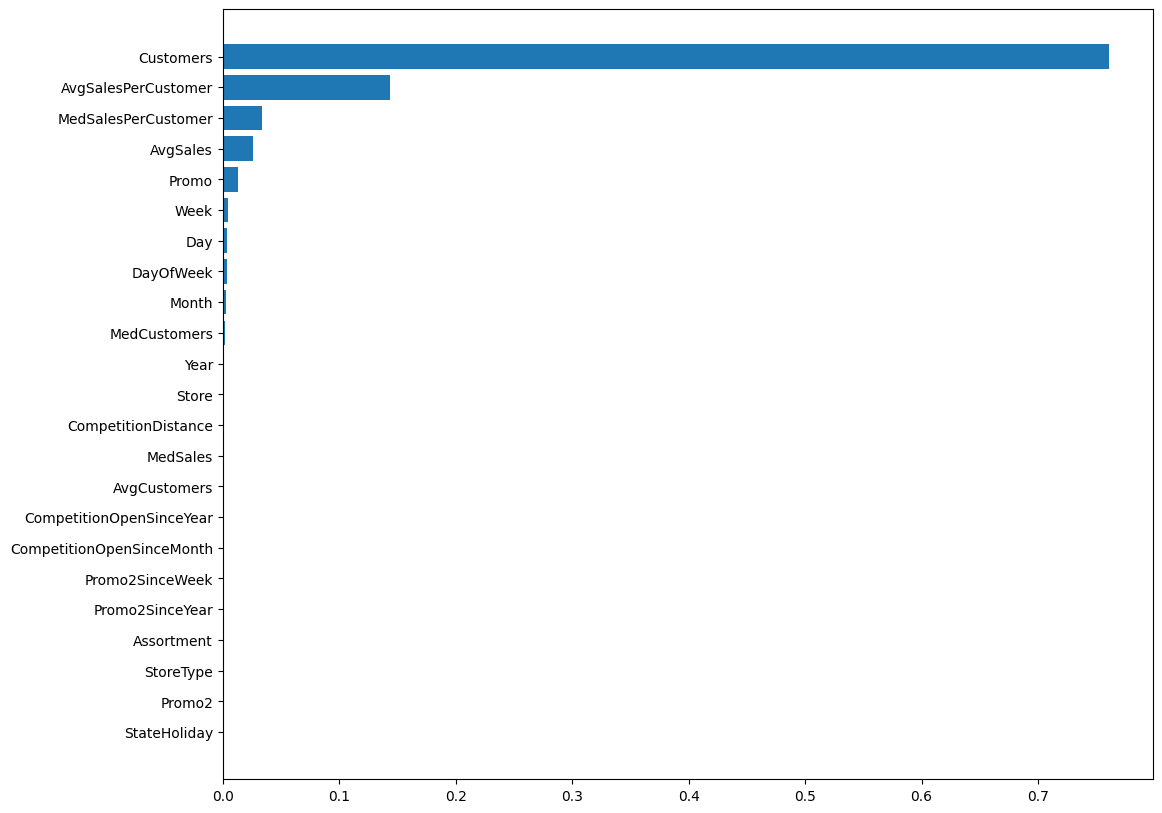

In [ ]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
plot_importance(decision_tree)

In [ ]:
y_hat = decision_tree.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)

Mean -0.08482487116494286
Variance 4.153782027243012e-07
RMSPE 0.08265669950573643


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.4s finished


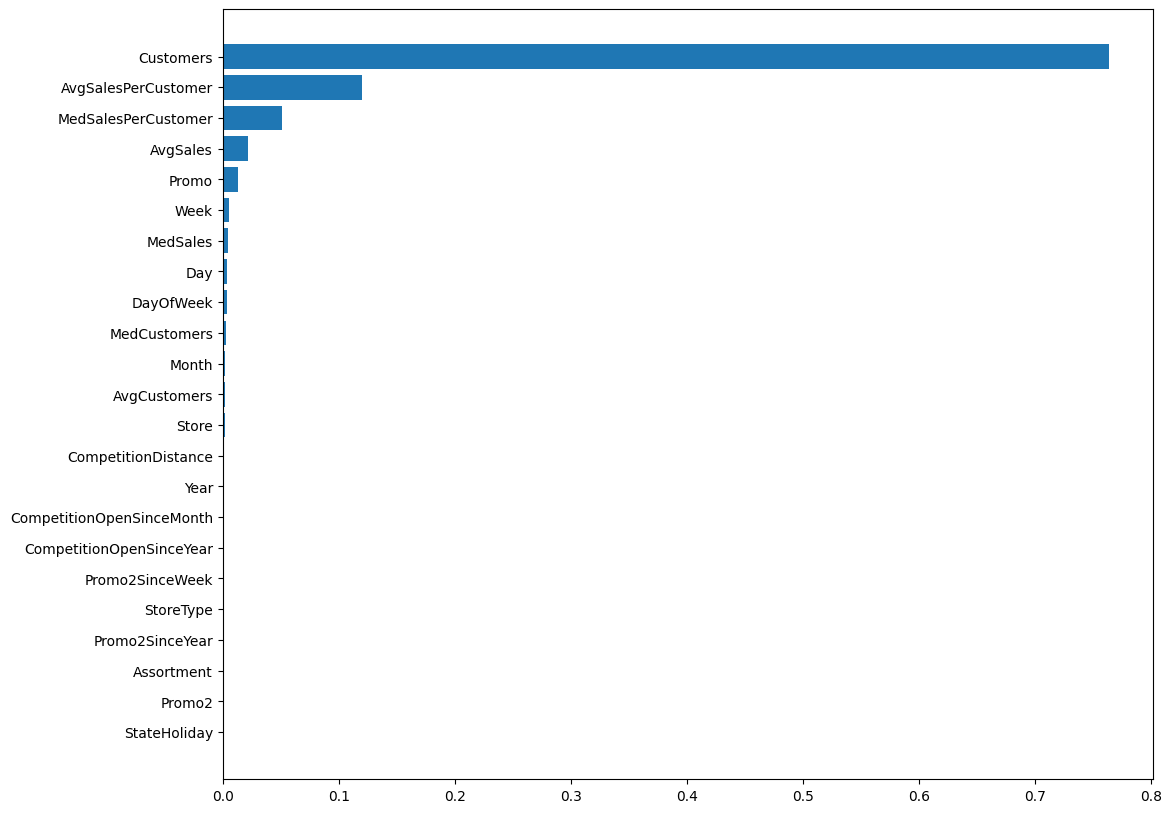

In [ ]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
plot_importance(randomForest)

In [ ]:
y_hat = randomForest.predict(X_test)
score(randomForest, X_train, y_train, y_test, y_hat)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jo

Mean -0.060806848335347455
Variance 8.230809394417313e-07
RMSPE 0.05977945956211959


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished


In [ ]:
import xgboost as xgb

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[X], np.log1p(y_train),
                 eval_set = [(X_train[X], np.log1p(y_train)), (X_test[X], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[03:08:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-rmse:7.53662	validation_0-rmspe:0.99957	validation_1-rmse:7.53602	validation_1-rmspe:0.99957
[1]	validation_0-rmse:6.78395	validation_0-rmspe:0.99892	validation_1-rmse:6.78345	validation_1-rmspe:0.99892
[2]	validation_0-rmse:6.10685	validation_0-rmspe:0.99774	validation_1-rmse:6.10628	validation_1-rmspe:0.99775
[3]	validation_0-rmse:5.49726	validation_0-rmspe:0.99575	validation_1-rmse:5.49674	validation_1-rmspe:0.99576
[4]	validation_0-rmse:4.94856	validation_0-rmspe:0.99258	validation_1-rmse:4.94791	validation_1-rmspe:0.99259
[5]	validation_0-rmse:4.45514	validation_0-rmspe:0.98779	validation_1-rmse:4.45441	validation_1-rmspe:0.98781
[6]	validation_0-rmse:4.01089	validation_0-rmspe:0.98097	validation_1-rmse:4.01002	validation_1-rmspe:0.98100
[7]	validation_0-rmse:3.61115	validation_0-rmspe:0.97168	validation_1-rmse:3.61021	validation_1-rmspe:0.97171
[8]	validation_0-rmse:3.25149	valida

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

Note that this is not in percentage, thus not to scale of graphs above


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

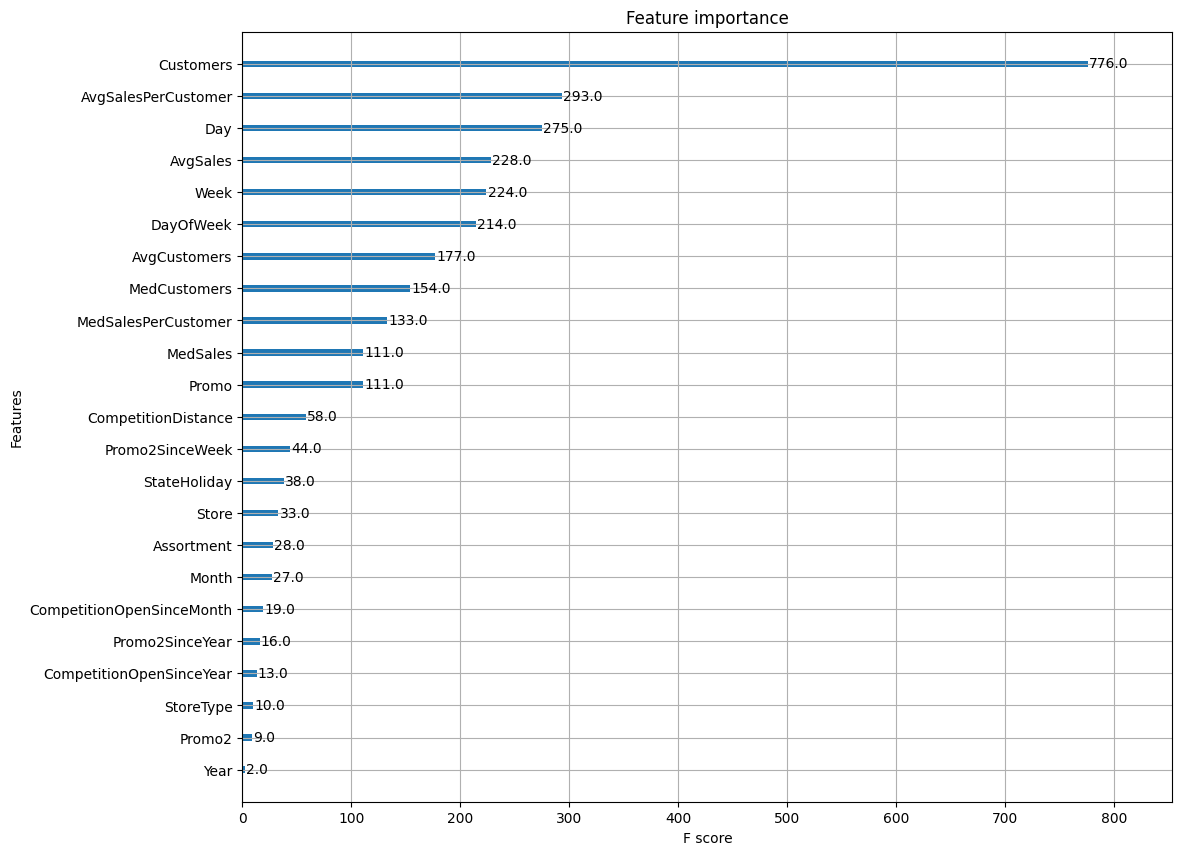

In [ ]:
print("Note that this is not in percentage, thus not to scale of graphs above")
xgb.plot_importance(xgboost_tree)

In [ ]:
def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, np.expm1(y_hat)))

y_hat = xgboost_tree.predict(X_test[X])
score(xgboost_tree, X_train[X], np.log1p(y_train), y_test, y_hat)

[03:10:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[03:10:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[03:10:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[03:11:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[03:11:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Mean -0.05552441237431418
Variance 4.680575195607904e-07
RMSPE 0.05429277897753211


In [ ]:
test = pd.read_csv("test_v2.csv", parse_dates=[2], dtype=types)
features = build_features(test, store)

y_hat = np.expm1(xgboost_tree.predict(features[X]))

df = pd.DataFrame({"Id": range(1, len(test) + 1), 'Sales': y_hat})
df.loc[test['Open'] == 0, 'Sales'] = 1
df.to_csv('sales.csv', index=False)

<ipython-input-28-8a9a0b9b30d9>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  merged['Week'] = merged.Date.dt.week
<ipython-input-28-8a9a0b9b30d9>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
